In [1]:
import pdb
# import visdom
import argparse
import numpy as np
from tqdm import tqdm
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
from torch.optim.lr_scheduler import MultiStepLR
from torchvision import datasets, transforms

import seaborn as sns  # import this after torch or it will break everything

from models.vgg import VGG
from models.densenet import DenseNet3
from models.wideresnet import WideResNet
from utils.utils import encode_onehot, CSVLogger, Cutout

## Hyper parameter

In [2]:
batch_size =128
epochs = 200
seed = 0
learning_rate = 0.1
data_augmentation = False
cutout = 16
budget = 0.3
baseline = False

# 爆速になるらしい
cudnn.benchmark = True
filename = 'cifar10' + '_' + 'vgg13' + '_budget_' + str(budget) + '_seed_' + str(seed)
np.random.seed(0)
torch.cuda.manual_seed(seed)

## Transform

In [3]:
normalize = transforms.Normalize(mean=[x / 255.0 for x in [125.3, 123.0, 113.9]], std=[x / 255.0 for x in [63.0, 62.1, 66.7]])

train_transform = transforms.Compose([])
train_transform.transforms.append(transforms.ToTensor())
train_transform.transforms.append(normalize)
train_transform.transforms.append(Cutout(cutout))

test_transform = transforms.Compose([transforms.ToTensor(), normalize])

## Dataset

In [4]:
num_classes = 10
train_dataset = datasets.CIFAR10(root='data/',
                                 train=True,
                                 transform=train_transform,
                                 download=True)

test_dataset = datasets.CIFAR10(root='data/',
                                train=False,
                                transform=test_transform,
                                download=True)

Files already downloaded and verified
Files already downloaded and verified


## Dataloader

In [5]:
train_loader = torch.utils.data.DataLoader(
                                           dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True,
                                           pin_memory=True,
                                           num_workers=2)

test_loader = torch.utils.data.DataLoader(
                                          dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False,
                                          pin_memory=True,
                                          num_workers=2)

## Plot histogram

In [6]:
def plot_histograms(corr, conf, bins=50, norm_hist=True):
    # Plot histogram of correctly classified and misclassified examples in visdom
    global conf_histogram

    plt.figure(figsize=(6, 4))
    sns.distplot(conf[corr], kde=False, bins=bins, norm_hist=norm_hist, label='Correct')
    sns.distplot(conf[np.invert(corr)], kde=False, bins=bins, norm_hist=norm_hist, label='Incorrect')
    plt.xlabel('Confidence')
    plt.ylabel('Density')
    plt.legend()

    # the image buffer acts as if it where a location on disk
    img_buffer = BytesIO()
    plt.savefig(img_buffer, bbox_inches='tight', pad_inches=0)
    img = Image.open(img_buffer)
    img = img.convert('RGB')
    img = torch.FloatTensor(np.array(img)).permute(2, 0, 1)
    #conf_histogram = vis.image(img, win=conf_histogram, opts=dict(title='Confidence Histogram'))

## Test mode

In [7]:
def test(loader):
    cnn.eval()    # Change model to 'eval' mode (BN uses moving mean/var).

    correct = []
    probability = []
    confidence = []

    for images, labels in loader:
        images = Variable(images, volatile=True).cuda()
        labels = labels.cuda()

        pred, conf = cnn(images)
        pred = F.softmax(pred, dim=-1)
        conf = F.sigmoid(conf).data.view(-1)

        pred_value, pred = torch.max(pred.data, 1)
        correct.extend((pred == labels).cpu().numpy())
        probability.extend(pred_value.cpu().numpy())
        confidence.extend(conf.cpu().numpy())

    correct = np.array(correct).astype(bool)
    probability = np.array(probability)
    confidence = np.array(confidence)

    plot_histograms(correct, confidence)

    val_acc = np.mean(correct)
    conf_min = np.min(confidence)
    conf_max = np.max(confidence)
    conf_avg = np.mean(confidence)

    cnn.train()
    return val_acc, conf_min, conf_max, conf_avg

## Model, Loss, Optimizer, Scheduler

In [8]:
cnn = VGG(vgg_name='VGG13', num_classes=num_classes).cuda()

prediction_criterion = nn.NLLLoss().cuda()
cnn_optimizer = torch.optim.SGD(cnn.parameters(), lr=learning_rate,
                                momentum=0.9, nesterov=True, weight_decay=5e-4)
scheduler = MultiStepLR(cnn_optimizer, milestones=[60, 120, 160], gamma=0.2)

## Csv logger

In [9]:
# csv_logger
csv_logger = CSVLogger(filename='logs/' + filename + '.csv',
                       fieldnames=['epoch', 'train_acc', 'test_acc'])

# Start with a reasonable guess for lambda
lmbda = 0.1

## Train

Epoch 0:   0%|          | 0/391 [00:00<?, ?it/s]/home/takano/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/takano/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/ipykernel_launcher.py:52: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/home/takano/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/ipykernel_launcher.py:54: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/home/takano/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/ipykernel_launcher.py:64: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item

test_acc: 0.324, conf_min: 0.654, conf_max: 0.984, conf_avg: 0.791


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.501, conf_min: 0.507, conf_max: 0.992, conf_avg: 0.760


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.570, conf_min: 0.454, conf_max: 0.999, conf_avg: 0.765


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.665, conf_min: 0.333, conf_max: 0.998, conf_avg: 0.707


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.676, conf_min: 0.338, conf_max: 1.000, conf_avg: 0.710


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.706, conf_min: 0.301, conf_max: 1.000, conf_avg: 0.731


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.766, conf_min: 0.318, conf_max: 1.000, conf_avg: 0.740


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.690, conf_min: 0.336, conf_max: 1.000, conf_avg: 0.775


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.778, conf_min: 0.283, conf_max: 1.000, conf_avg: 0.775


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.729, conf_min: 0.365, conf_max: 1.000, conf_avg: 0.840


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.750, conf_min: 0.267, conf_max: 1.000, conf_avg: 0.789


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.773, conf_min: 0.325, conf_max: 1.000, conf_avg: 0.827


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.757, conf_min: 0.284, conf_max: 1.000, conf_avg: 0.729


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.775, conf_min: 0.297, conf_max: 1.000, conf_avg: 0.811


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.755, conf_min: 0.314, conf_max: 1.000, conf_avg: 0.758


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.792, conf_min: 0.307, conf_max: 1.000, conf_avg: 0.815


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.755, conf_min: 0.251, conf_max: 1.000, conf_avg: 0.723


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.666, conf_min: 0.246, conf_max: 1.000, conf_avg: 0.755


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.767, conf_min: 0.263, conf_max: 1.000, conf_avg: 0.781


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.784, conf_min: 0.254, conf_max: 1.000, conf_avg: 0.783


Epoch 20: 100%|██████████| 391/391 [00:12<00:00, 31.44it/s, acc=0.000, confidence_loss=0.300, xentropy=0.303]
/home/takano/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.796, conf_min: 0.305, conf_max: 1.000, conf_avg: 0.823


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.779, conf_min: 0.233, conf_max: 1.000, conf_avg: 0.780


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.787, conf_min: 0.230, conf_max: 1.000, conf_avg: 0.787


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.814, conf_min: 0.208, conf_max: 1.000, conf_avg: 0.764


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.761, conf_min: 0.245, conf_max: 1.000, conf_avg: 0.799


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.804, conf_min: 0.194, conf_max: 1.000, conf_avg: 0.784


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.693, conf_min: 0.242, conf_max: 1.000, conf_avg: 0.738


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.793, conf_min: 0.251, conf_max: 1.000, conf_avg: 0.757


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.775, conf_min: 0.342, conf_max: 1.000, conf_avg: 0.803


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.768, conf_min: 0.296, conf_max: 1.000, conf_avg: 0.804


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.756, conf_min: 0.183, conf_max: 1.000, conf_avg: 0.739


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.795, conf_min: 0.191, conf_max: 1.000, conf_avg: 0.761


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.826, conf_min: 0.279, conf_max: 1.000, conf_avg: 0.837


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.818, conf_min: 0.314, conf_max: 1.000, conf_avg: 0.827


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.833, conf_min: 0.227, conf_max: 1.000, conf_avg: 0.806


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.802, conf_min: 0.212, conf_max: 1.000, conf_avg: 0.738


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.825, conf_min: 0.287, conf_max: 1.000, conf_avg: 0.831


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.763, conf_min: 0.246, conf_max: 1.000, conf_avg: 0.768


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.783, conf_min: 0.189, conf_max: 1.000, conf_avg: 0.757


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.819, conf_min: 0.231, conf_max: 1.000, conf_avg: 0.804


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.792, conf_min: 0.230, conf_max: 1.000, conf_avg: 0.795


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.788, conf_min: 0.195, conf_max: 1.000, conf_avg: 0.763


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.787, conf_min: 0.217, conf_max: 1.000, conf_avg: 0.753


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.801, conf_min: 0.216, conf_max: 1.000, conf_avg: 0.775


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.807, conf_min: 0.235, conf_max: 1.000, conf_avg: 0.789


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.802, conf_min: 0.244, conf_max: 1.000, conf_avg: 0.806


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.821, conf_min: 0.216, conf_max: 1.000, conf_avg: 0.740


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.811, conf_min: 0.220, conf_max: 1.000, conf_avg: 0.799


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.838, conf_min: 0.198, conf_max: 1.000, conf_avg: 0.802


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.813, conf_min: 0.263, conf_max: 1.000, conf_avg: 0.799


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.815, conf_min: 0.262, conf_max: 1.000, conf_avg: 0.807


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.785, conf_min: 0.216, conf_max: 1.000, conf_avg: 0.732


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.827, conf_min: 0.196, conf_max: 1.000, conf_avg: 0.748


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.814, conf_min: 0.225, conf_max: 1.000, conf_avg: 0.789


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.763, conf_min: 0.186, conf_max: 1.000, conf_avg: 0.738


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.809, conf_min: 0.228, conf_max: 1.000, conf_avg: 0.791


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.805, conf_min: 0.247, conf_max: 1.000, conf_avg: 0.782


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.801, conf_min: 0.186, conf_max: 1.000, conf_avg: 0.778


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.785, conf_min: 0.178, conf_max: 1.000, conf_avg: 0.710


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.781, conf_min: 0.180, conf_max: 1.000, conf_avg: 0.682


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.817, conf_min: 0.202, conf_max: 1.000, conf_avg: 0.771


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.894, conf_min: 0.128, conf_max: 1.000, conf_avg: 0.806


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.896, conf_min: 0.119, conf_max: 1.000, conf_avg: 0.817


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.895, conf_min: 0.073, conf_max: 1.000, conf_avg: 0.791


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.893, conf_min: 0.088, conf_max: 1.000, conf_avg: 0.807


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.889, conf_min: 0.075, conf_max: 1.000, conf_avg: 0.795


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.891, conf_min: 0.053, conf_max: 1.000, conf_avg: 0.800


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.889, conf_min: 0.057, conf_max: 1.000, conf_avg: 0.796


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.879, conf_min: 0.060, conf_max: 1.000, conf_avg: 0.796


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.877, conf_min: 0.059, conf_max: 1.000, conf_avg: 0.783


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.879, conf_min: 0.068, conf_max: 1.000, conf_avg: 0.787


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.884, conf_min: 0.060, conf_max: 1.000, conf_avg: 0.789


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.886, conf_min: 0.066, conf_max: 1.000, conf_avg: 0.798


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.872, conf_min: 0.064, conf_max: 1.000, conf_avg: 0.785


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.885, conf_min: 0.078, conf_max: 1.000, conf_avg: 0.792


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.880, conf_min: 0.073, conf_max: 1.000, conf_avg: 0.813


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.878, conf_min: 0.081, conf_max: 1.000, conf_avg: 0.778


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.869, conf_min: 0.078, conf_max: 1.000, conf_avg: 0.802


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.873, conf_min: 0.069, conf_max: 1.000, conf_avg: 0.796


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.857, conf_min: 0.099, conf_max: 1.000, conf_avg: 0.799


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.874, conf_min: 0.090, conf_max: 1.000, conf_avg: 0.807


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.871, conf_min: 0.080, conf_max: 1.000, conf_avg: 0.801


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.868, conf_min: 0.078, conf_max: 1.000, conf_avg: 0.796


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.866, conf_min: 0.088, conf_max: 1.000, conf_avg: 0.788


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.863, conf_min: 0.069, conf_max: 1.000, conf_avg: 0.760


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.870, conf_min: 0.067, conf_max: 1.000, conf_avg: 0.777


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.866, conf_min: 0.100, conf_max: 1.000, conf_avg: 0.800


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.861, conf_min: 0.079, conf_max: 1.000, conf_avg: 0.793


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.837, conf_min: 0.071, conf_max: 1.000, conf_avg: 0.779


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.875, conf_min: 0.076, conf_max: 1.000, conf_avg: 0.782


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.837, conf_min: 0.104, conf_max: 1.000, conf_avg: 0.790


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.873, conf_min: 0.128, conf_max: 1.000, conf_avg: 0.811


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.874, conf_min: 0.087, conf_max: 1.000, conf_avg: 0.792


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.863, conf_min: 0.076, conf_max: 1.000, conf_avg: 0.785


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.860, conf_min: 0.068, conf_max: 1.000, conf_avg: 0.776


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.854, conf_min: 0.103, conf_max: 1.000, conf_avg: 0.818


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.874, conf_min: 0.083, conf_max: 1.000, conf_avg: 0.799


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.884, conf_min: 0.100, conf_max: 1.000, conf_avg: 0.786


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.854, conf_min: 0.077, conf_max: 1.000, conf_avg: 0.771


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.854, conf_min: 0.071, conf_max: 1.000, conf_avg: 0.766


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.863, conf_min: 0.078, conf_max: 1.000, conf_avg: 0.791


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.852, conf_min: 0.094, conf_max: 1.000, conf_avg: 0.799


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.860, conf_min: 0.079, conf_max: 1.000, conf_avg: 0.763


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.849, conf_min: 0.099, conf_max: 1.000, conf_avg: 0.791


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.878, conf_min: 0.079, conf_max: 1.000, conf_avg: 0.772


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.861, conf_min: 0.082, conf_max: 1.000, conf_avg: 0.788


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.856, conf_min: 0.091, conf_max: 1.000, conf_avg: 0.785


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.872, conf_min: 0.075, conf_max: 1.000, conf_avg: 0.771


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.874, conf_min: 0.063, conf_max: 1.000, conf_avg: 0.786


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.870, conf_min: 0.067, conf_max: 1.000, conf_avg: 0.769


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.856, conf_min: 0.062, conf_max: 1.000, conf_avg: 0.794


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.867, conf_min: 0.075, conf_max: 1.000, conf_avg: 0.775


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.860, conf_min: 0.067, conf_max: 1.000, conf_avg: 0.766


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.865, conf_min: 0.094, conf_max: 1.000, conf_avg: 0.785


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.854, conf_min: 0.062, conf_max: 1.000, conf_avg: 0.776


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.868, conf_min: 0.080, conf_max: 1.000, conf_avg: 0.795


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.864, conf_min: 0.076, conf_max: 1.000, conf_avg: 0.795


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.873, conf_min: 0.078, conf_max: 1.000, conf_avg: 0.787


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.854, conf_min: 0.071, conf_max: 1.000, conf_avg: 0.757


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.872, conf_min: 0.107, conf_max: 1.000, conf_avg: 0.815


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.875, conf_min: 0.078, conf_max: 1.000, conf_avg: 0.775


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.901, conf_min: 0.049, conf_max: 1.000, conf_avg: 0.758


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.902, conf_min: 0.057, conf_max: 1.000, conf_avg: 0.772


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.905, conf_min: 0.039, conf_max: 1.000, conf_avg: 0.744


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.903, conf_min: 0.048, conf_max: 1.000, conf_avg: 0.758


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.902, conf_min: 0.040, conf_max: 1.000, conf_avg: 0.745


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.906, conf_min: 0.040, conf_max: 1.000, conf_avg: 0.753


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.904, conf_min: 0.032, conf_max: 1.000, conf_avg: 0.739


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.905, conf_min: 0.044, conf_max: 1.000, conf_avg: 0.746


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.901, conf_min: 0.030, conf_max: 1.000, conf_avg: 0.739


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.903, conf_min: 0.037, conf_max: 1.000, conf_avg: 0.733


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.906, conf_min: 0.041, conf_max: 1.000, conf_avg: 0.732


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.904, conf_min: 0.036, conf_max: 1.000, conf_avg: 0.735


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.903, conf_min: 0.025, conf_max: 1.000, conf_avg: 0.735


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.906, conf_min: 0.026, conf_max: 1.000, conf_avg: 0.741


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.905, conf_min: 0.033, conf_max: 1.000, conf_avg: 0.730


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.905, conf_min: 0.032, conf_max: 1.000, conf_avg: 0.737


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.905, conf_min: 0.034, conf_max: 1.000, conf_avg: 0.730


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.906, conf_min: 0.036, conf_max: 1.000, conf_avg: 0.737


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.905, conf_min: 0.037, conf_max: 1.000, conf_avg: 0.725


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.907, conf_min: 0.035, conf_max: 1.000, conf_avg: 0.733


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.908, conf_min: 0.033, conf_max: 1.000, conf_avg: 0.723


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.904, conf_min: 0.038, conf_max: 1.000, conf_avg: 0.730


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.906, conf_min: 0.033, conf_max: 1.000, conf_avg: 0.727


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.906, conf_min: 0.034, conf_max: 1.000, conf_avg: 0.721


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.905, conf_min: 0.044, conf_max: 1.000, conf_avg: 0.735


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.905, conf_min: 0.033, conf_max: 1.000, conf_avg: 0.724


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.907, conf_min: 0.040, conf_max: 1.000, conf_avg: 0.728


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.904, conf_min: 0.032, conf_max: 1.000, conf_avg: 0.716


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.904, conf_min: 0.038, conf_max: 1.000, conf_avg: 0.736


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.904, conf_min: 0.032, conf_max: 1.000, conf_avg: 0.719


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.907, conf_min: 0.051, conf_max: 1.000, conf_avg: 0.741


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.904, conf_min: 0.030, conf_max: 1.000, conf_avg: 0.714


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.908, conf_min: 0.042, conf_max: 1.000, conf_avg: 0.731


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.904, conf_min: 0.036, conf_max: 1.000, conf_avg: 0.716


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.903, conf_min: 0.036, conf_max: 1.000, conf_avg: 0.724


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.905, conf_min: 0.038, conf_max: 1.000, conf_avg: 0.728


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.903, conf_min: 0.039, conf_max: 1.000, conf_avg: 0.718


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.902, conf_min: 0.033, conf_max: 1.000, conf_avg: 0.722


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.902, conf_min: 0.039, conf_max: 1.000, conf_avg: 0.725


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.903, conf_min: 0.029, conf_max: 1.000, conf_avg: 0.712


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.905, conf_min: 0.034, conf_max: 1.000, conf_avg: 0.720


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.907, conf_min: 0.034, conf_max: 1.000, conf_avg: 0.718


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.909, conf_min: 0.031, conf_max: 1.000, conf_avg: 0.715


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.910, conf_min: 0.031, conf_max: 1.000, conf_avg: 0.707


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.910, conf_min: 0.033, conf_max: 1.000, conf_avg: 0.708


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.912, conf_min: 0.034, conf_max: 1.000, conf_avg: 0.712


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.911, conf_min: 0.031, conf_max: 1.000, conf_avg: 0.710


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.910, conf_min: 0.032, conf_max: 1.000, conf_avg: 0.709


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.911, conf_min: 0.029, conf_max: 1.000, conf_avg: 0.699


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.909, conf_min: 0.035, conf_max: 1.000, conf_avg: 0.699


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.911, conf_min: 0.039, conf_max: 1.000, conf_avg: 0.708


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.910, conf_min: 0.034, conf_max: 1.000, conf_avg: 0.703


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.910, conf_min: 0.035, conf_max: 1.000, conf_avg: 0.699


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.910, conf_min: 0.037, conf_max: 1.000, conf_avg: 0.705


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.911, conf_min: 0.039, conf_max: 1.000, conf_avg: 0.708


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.908, conf_min: 0.039, conf_max: 1.000, conf_avg: 0.697


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.910, conf_min: 0.039, conf_max: 1.000, conf_avg: 0.700


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.911, conf_min: 0.041, conf_max: 1.000, conf_avg: 0.698


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.912, conf_min: 0.035, conf_max: 1.000, conf_avg: 0.695


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.911, conf_min: 0.040, conf_max: 1.000, conf_avg: 0.696


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.910, conf_min: 0.044, conf_max: 1.000, conf_avg: 0.698


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.910, conf_min: 0.039, conf_max: 1.000, conf_avg: 0.697


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.910, conf_min: 0.042, conf_max: 1.000, conf_avg: 0.698


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.912, conf_min: 0.041, conf_max: 1.000, conf_avg: 0.701


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.911, conf_min: 0.045, conf_max: 1.000, conf_avg: 0.697


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.911, conf_min: 0.045, conf_max: 1.000, conf_avg: 0.696


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.911, conf_min: 0.045, conf_max: 1.000, conf_avg: 0.698


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.913, conf_min: 0.042, conf_max: 1.000, conf_avg: 0.692


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.911, conf_min: 0.042, conf_max: 0.999, conf_avg: 0.690


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.912, conf_min: 0.049, conf_max: 0.999, conf_avg: 0.694


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.911, conf_min: 0.047, conf_max: 0.999, conf_avg: 0.696


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.909, conf_min: 0.046, conf_max: 0.999, conf_avg: 0.699


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.910, conf_min: 0.048, conf_max: 0.999, conf_avg: 0.695


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.911, conf_min: 0.047, conf_max: 0.999, conf_avg: 0.693


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.911, conf_min: 0.048, conf_max: 0.999, conf_avg: 0.692


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.910, conf_min: 0.044, conf_max: 0.999, conf_avg: 0.691


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.911, conf_min: 0.040, conf_max: 0.999, conf_avg: 0.688


  0%|          | 0/391 [00:00<?, ?it/s]

test_acc: 0.912, conf_min: 0.042, conf_max: 0.999, conf_avg: 0.689


Epoch 199: 100%|██████████| 391/391 [00:12<00:00, 31.69it/s, acc=0.000, confidence_loss=0.298, xentropy=0.006]


test_acc: 0.911, conf_min: 0.044, conf_max: 0.999, conf_avg: 0.695


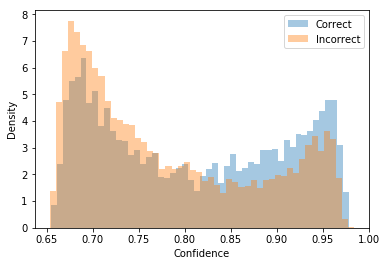

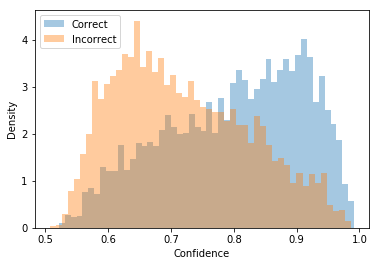

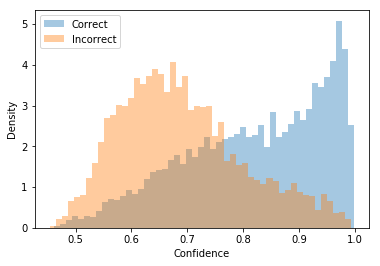

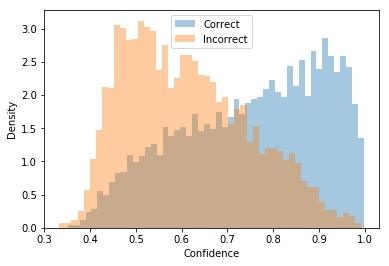

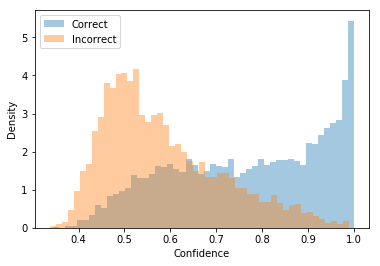

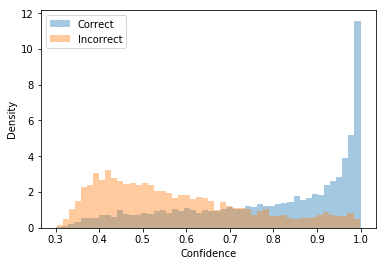

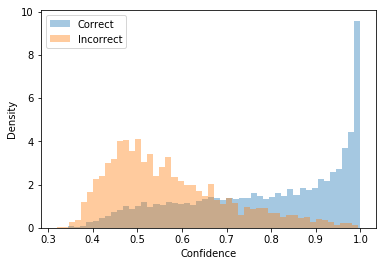

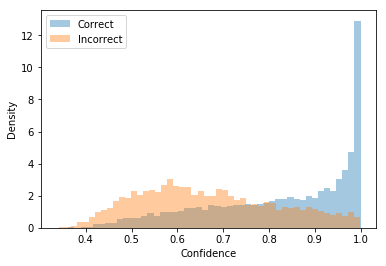

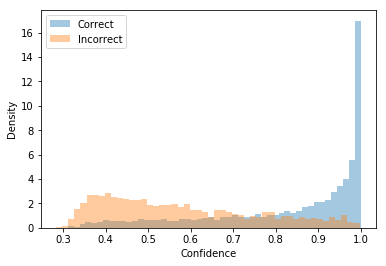

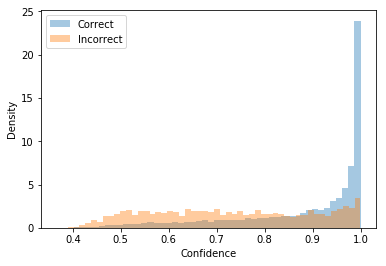

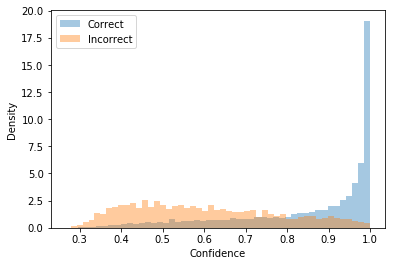

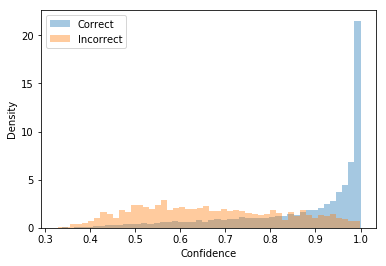

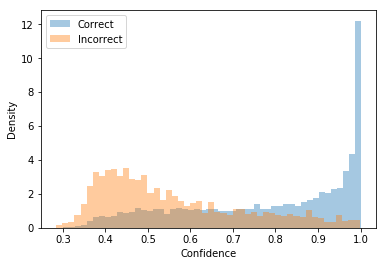

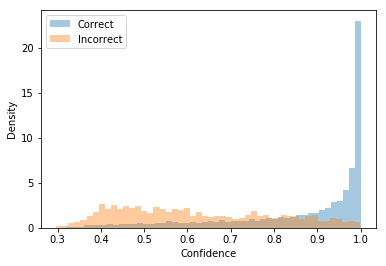

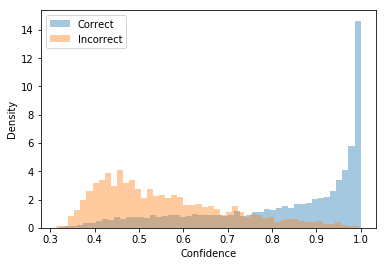

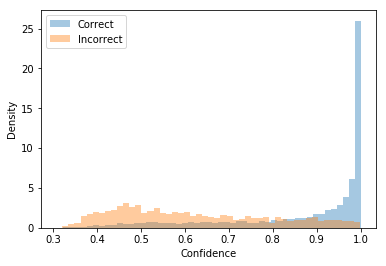

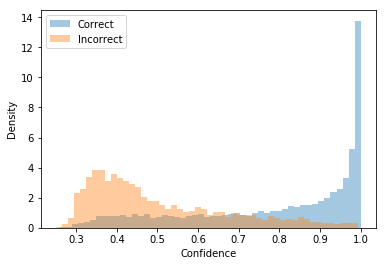

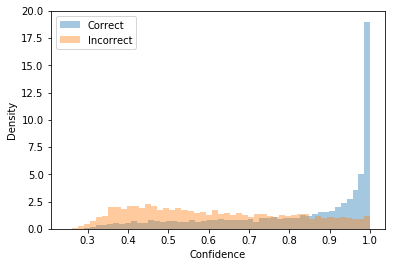

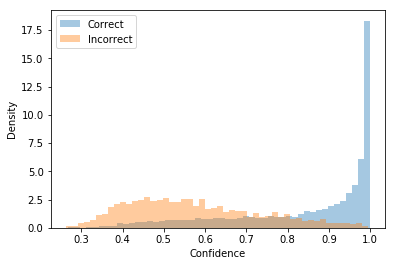

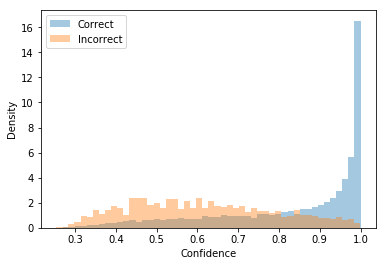

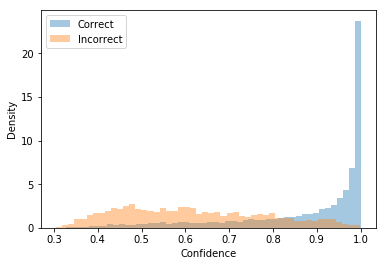

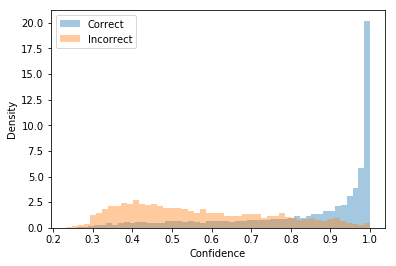

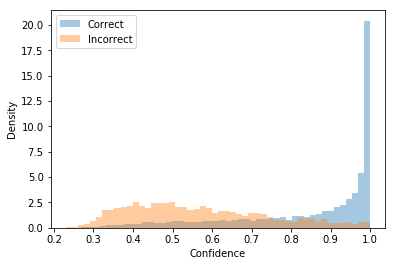

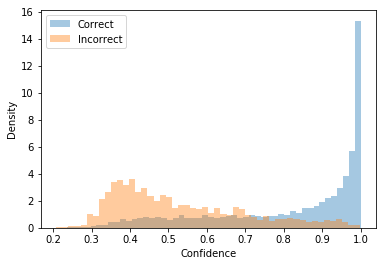

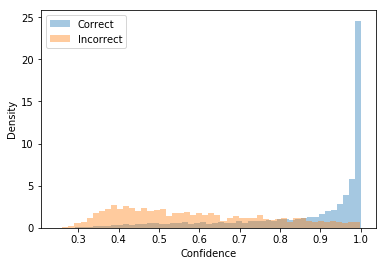

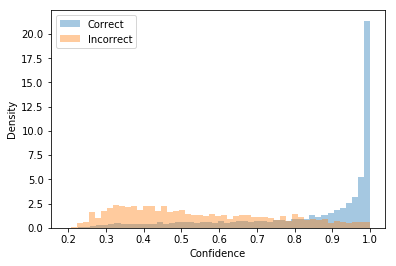

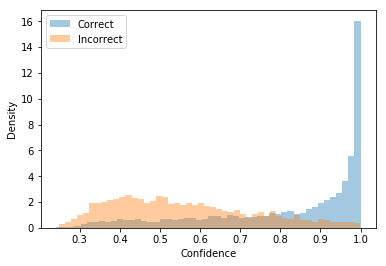

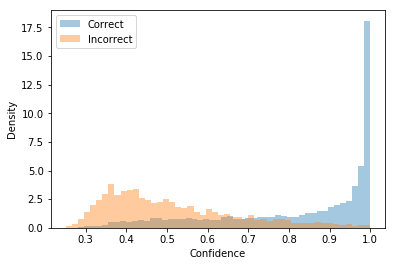

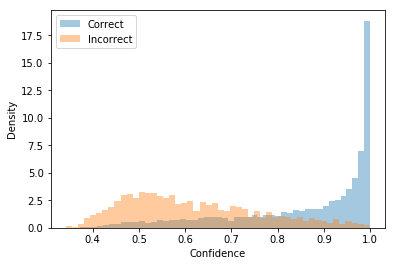

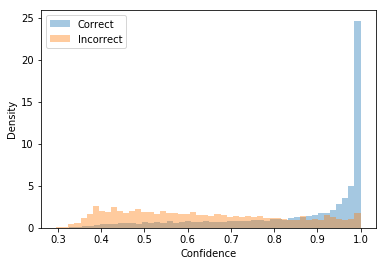

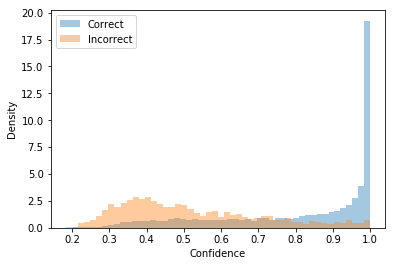

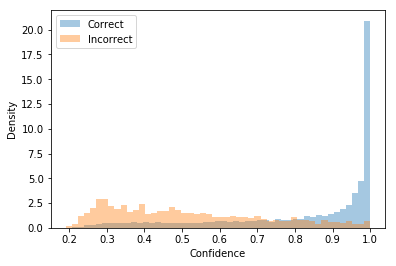

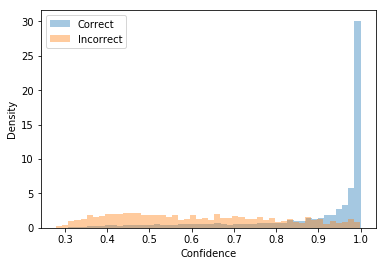

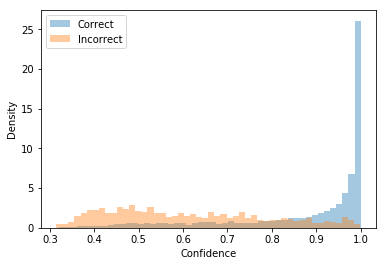

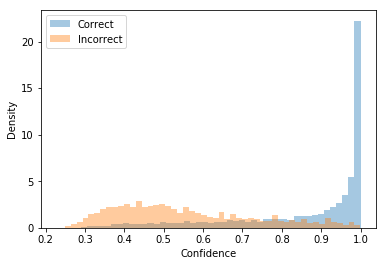

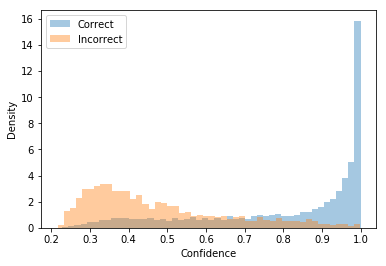

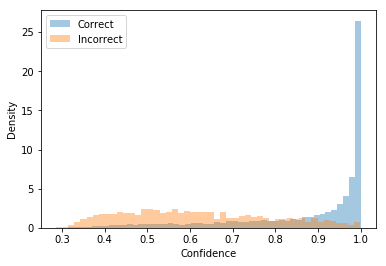

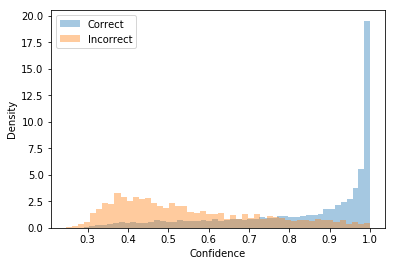

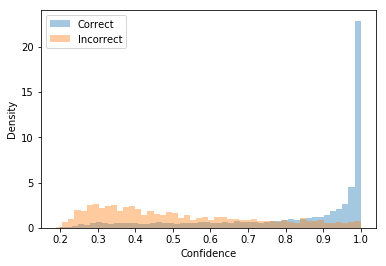

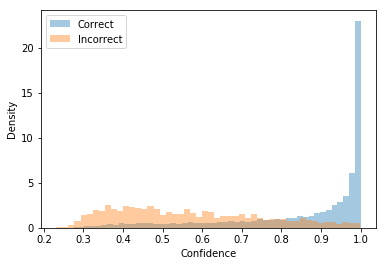

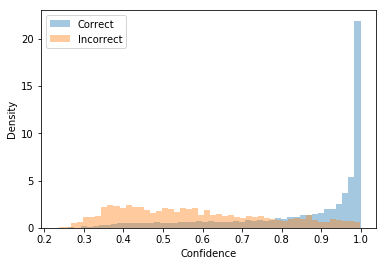

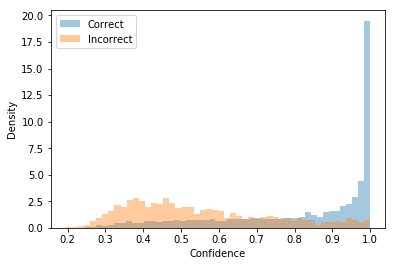

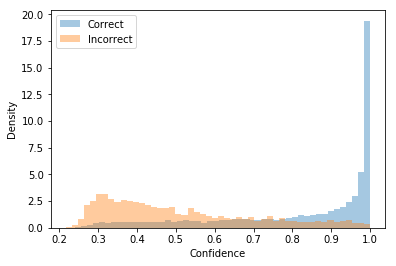

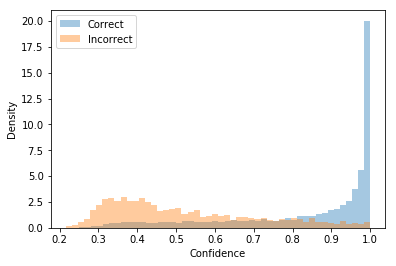

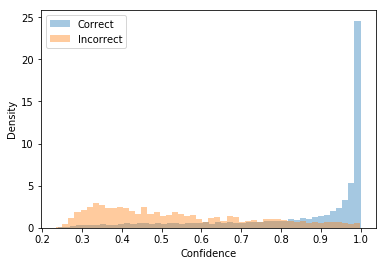

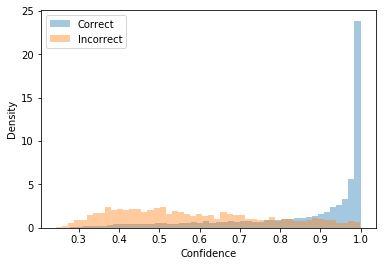

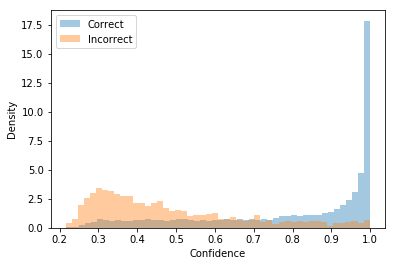

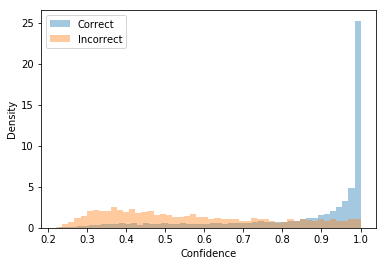

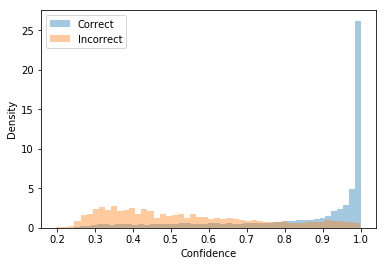

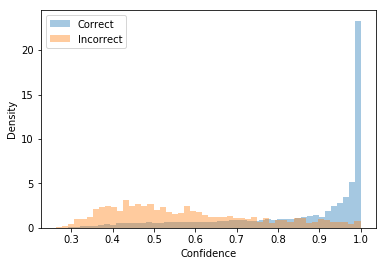

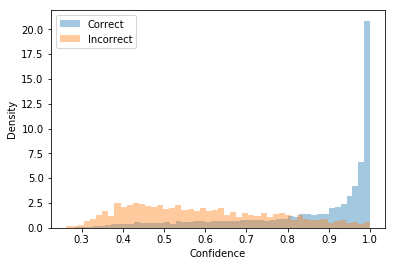

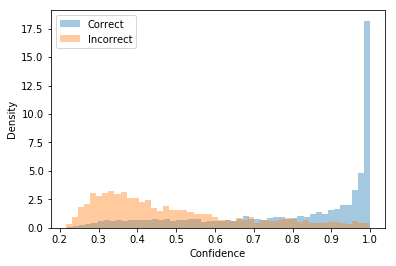

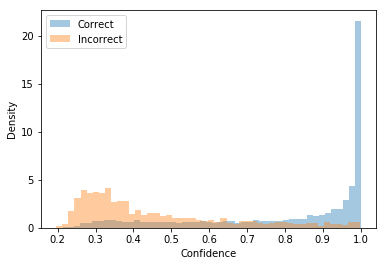

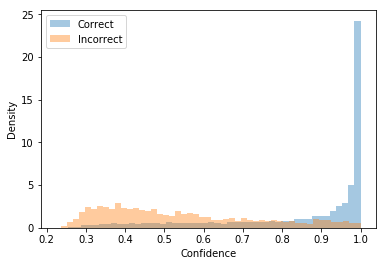

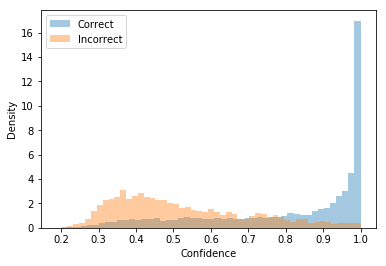

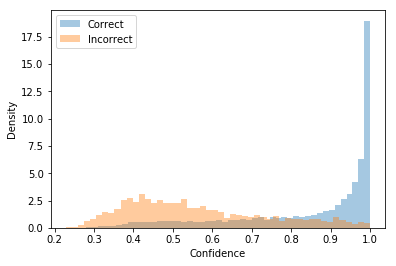

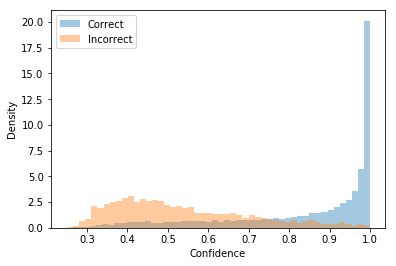

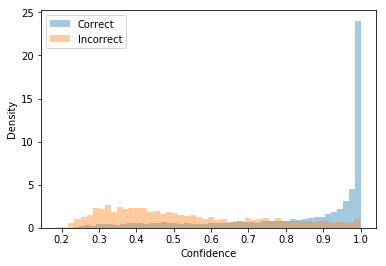

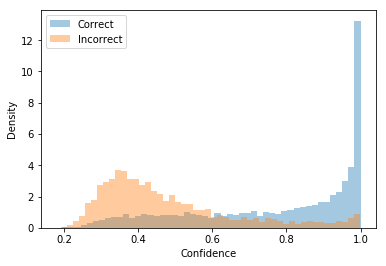

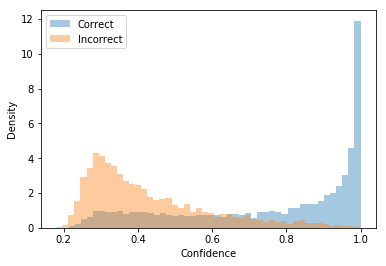

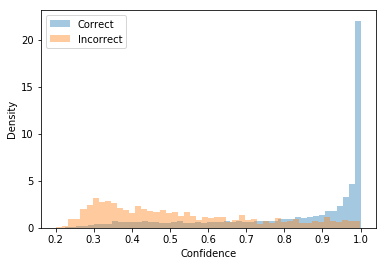

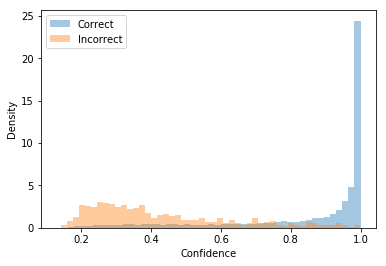

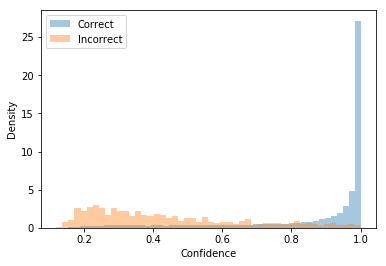

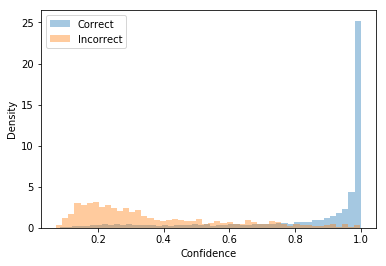

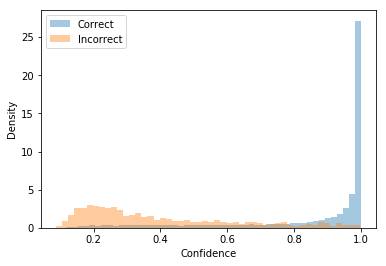

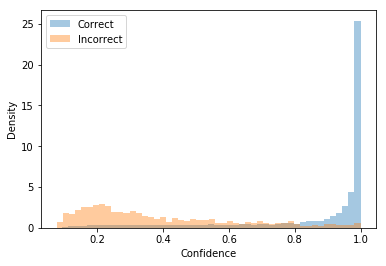

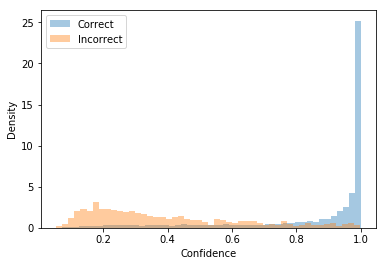

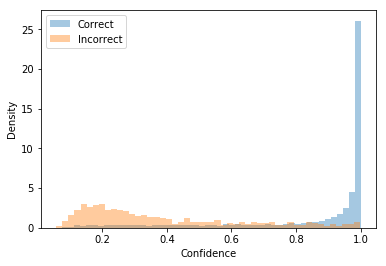

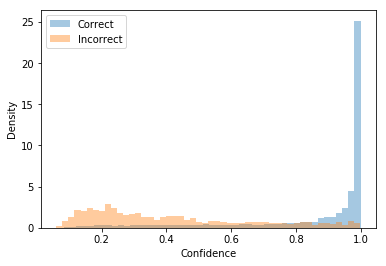

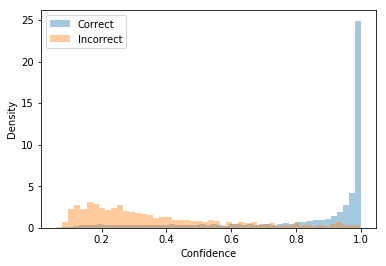

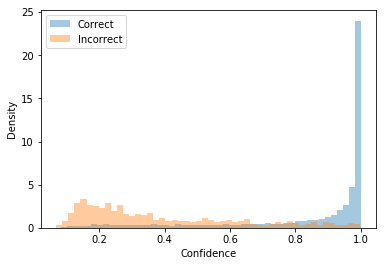

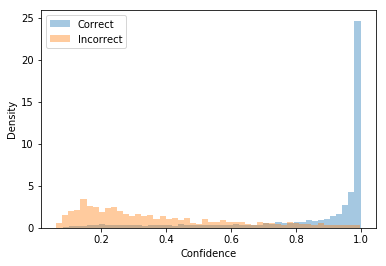

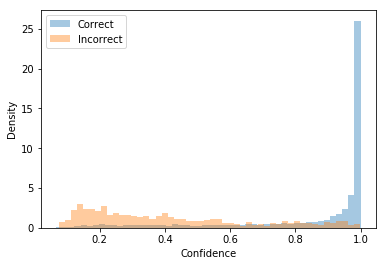

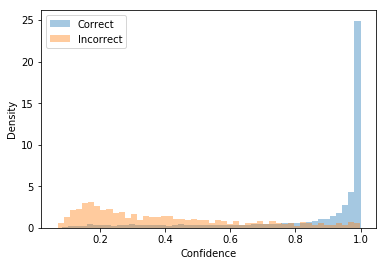

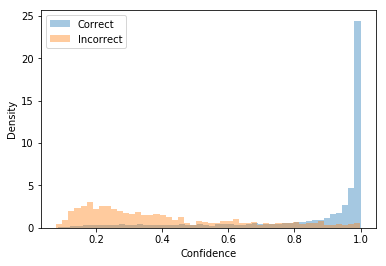

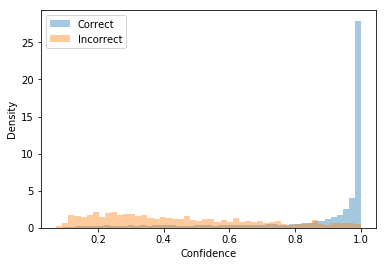

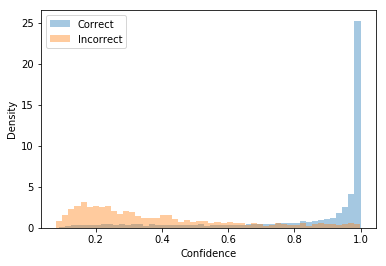

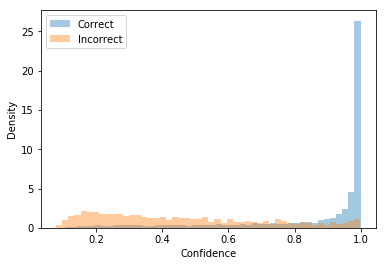

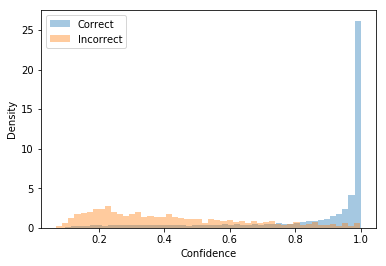

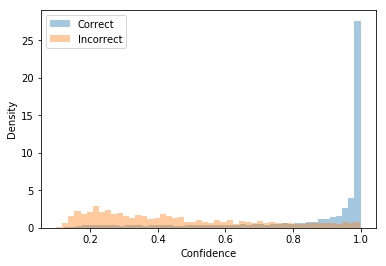

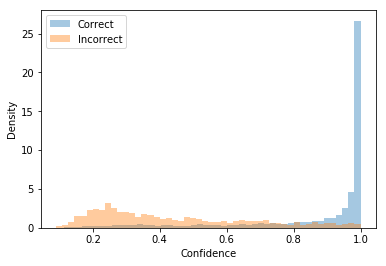

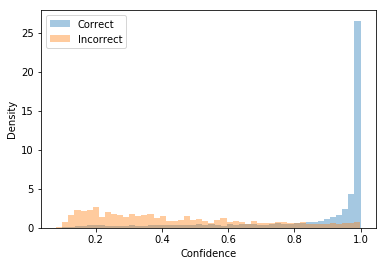

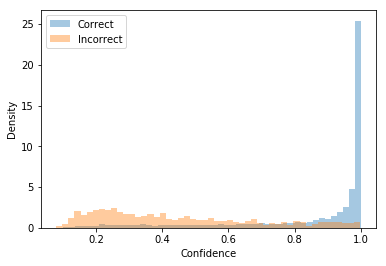

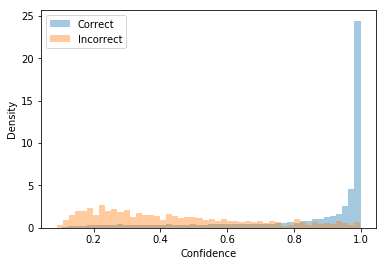

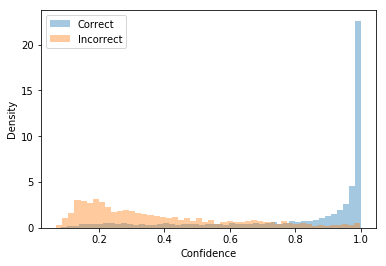

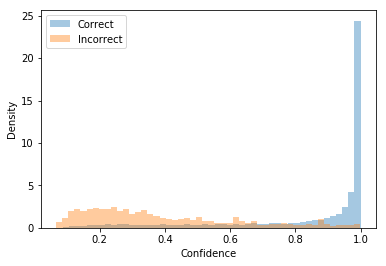

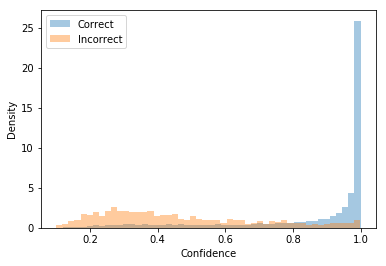

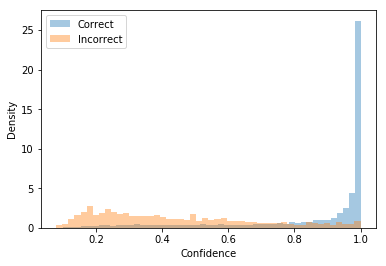

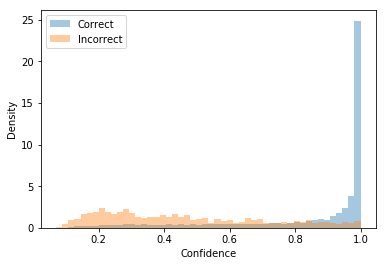

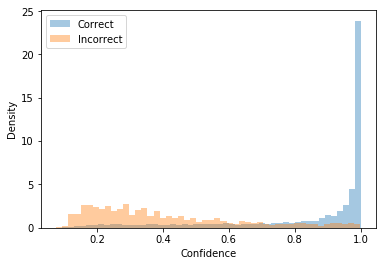

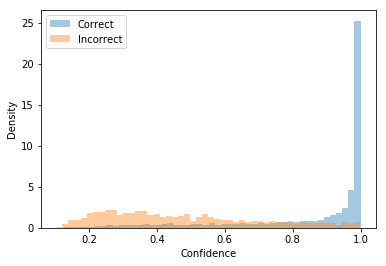

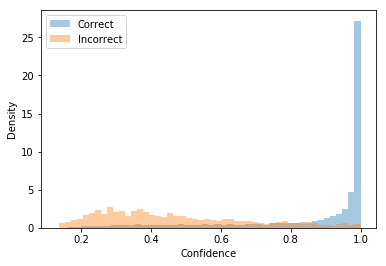

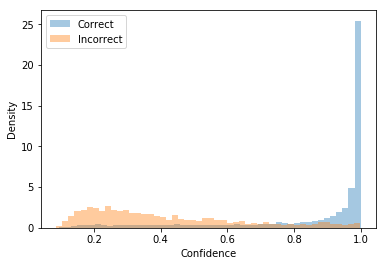

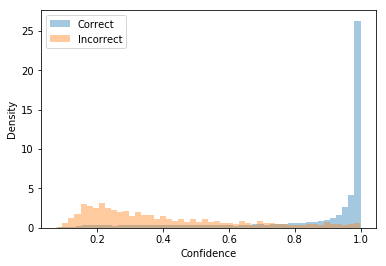

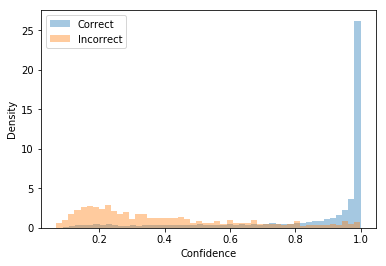

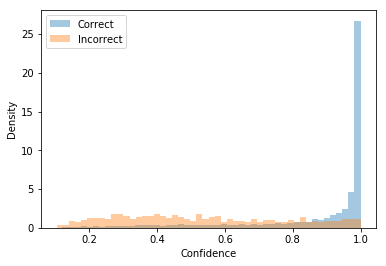

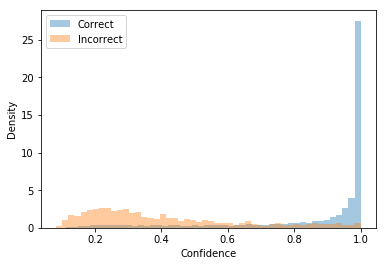

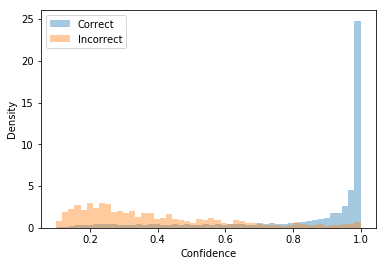

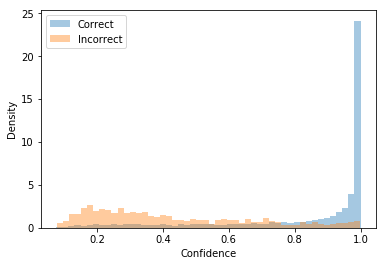

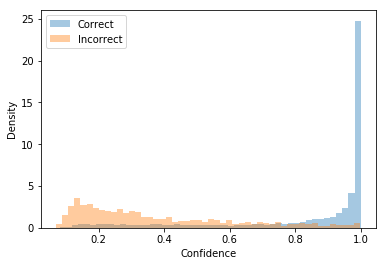

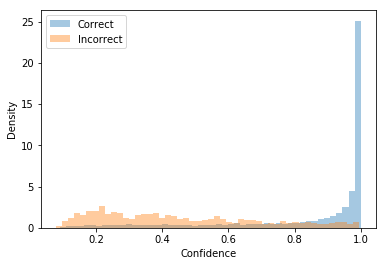

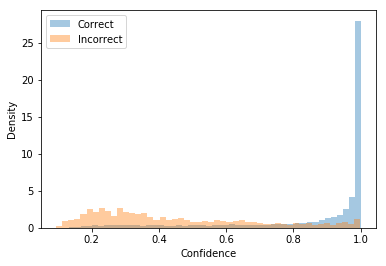

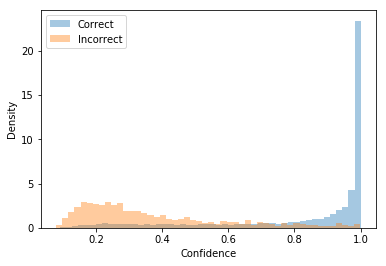

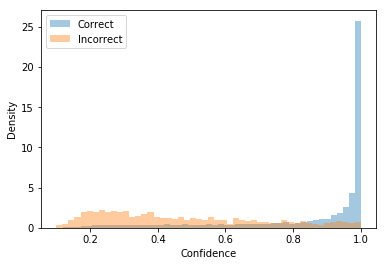

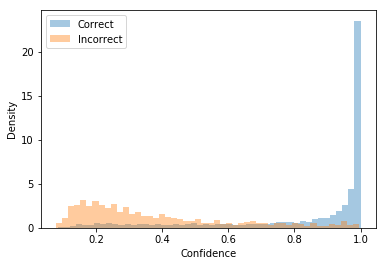

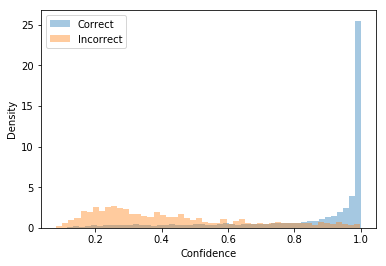

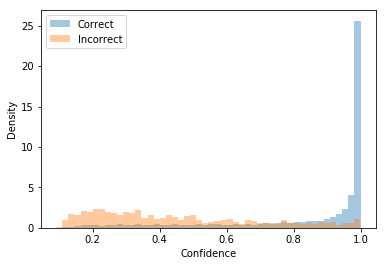

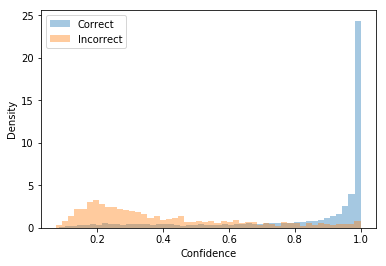

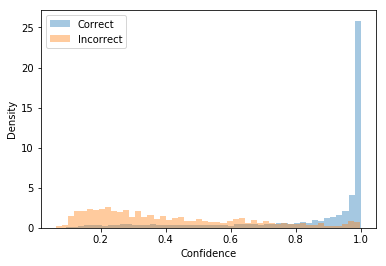

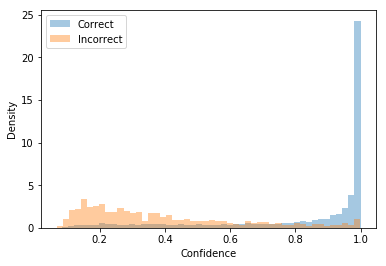

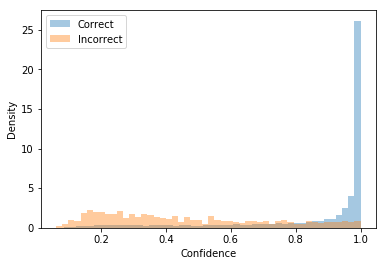

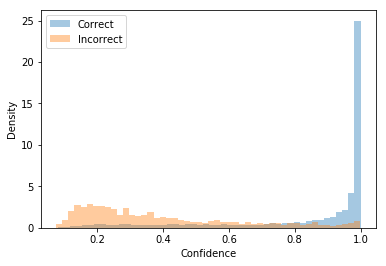

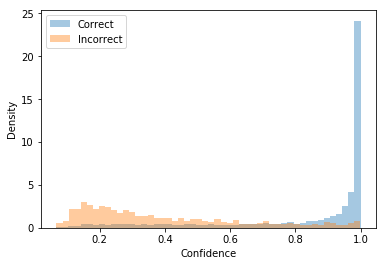

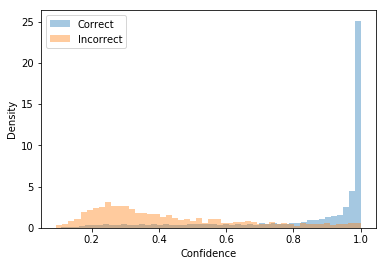

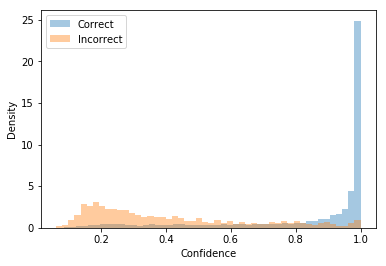

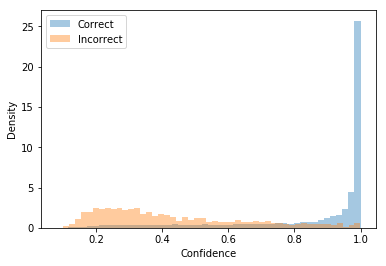

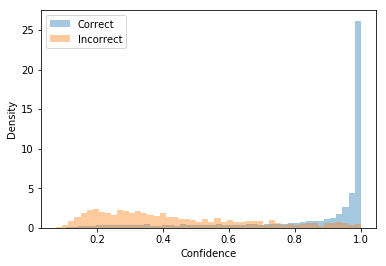

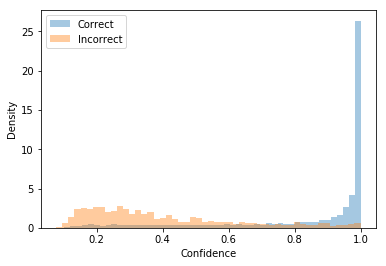

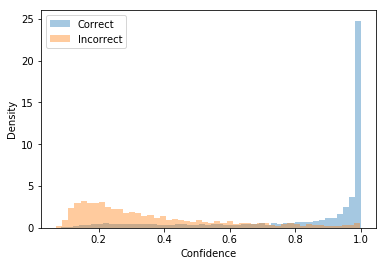

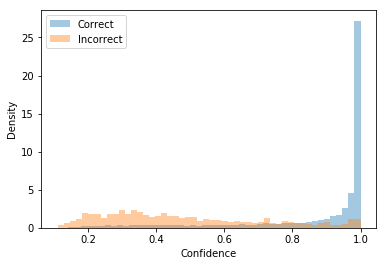

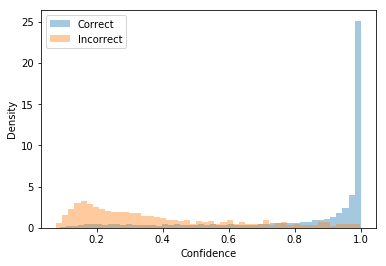

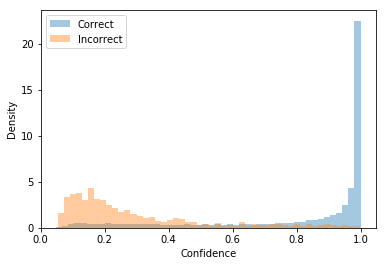

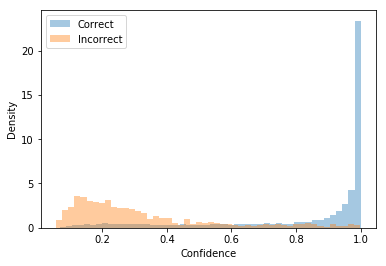

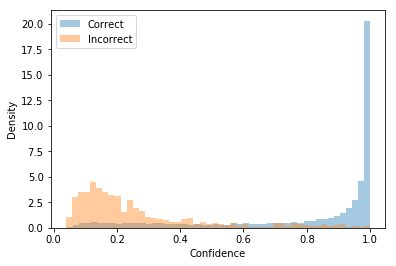

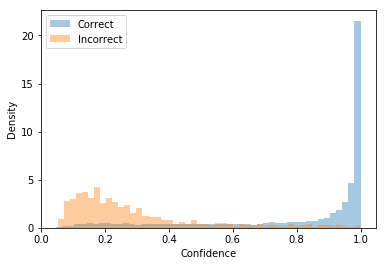

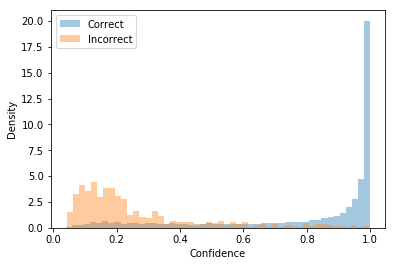

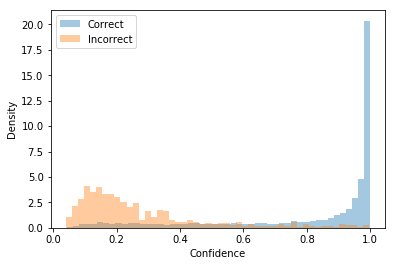

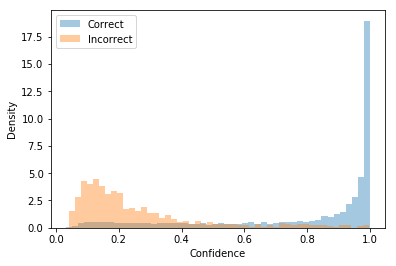

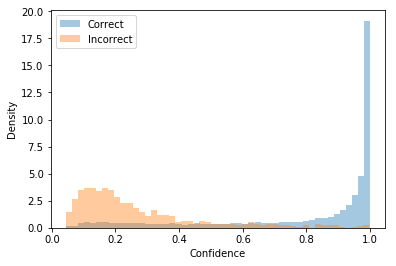

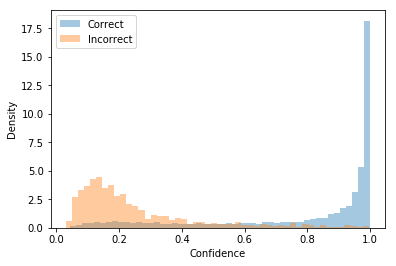

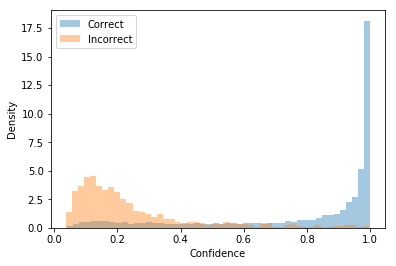

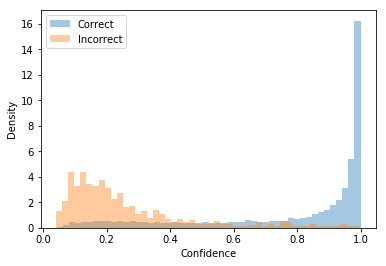

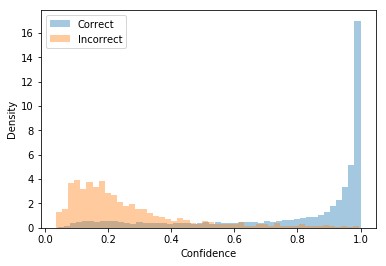

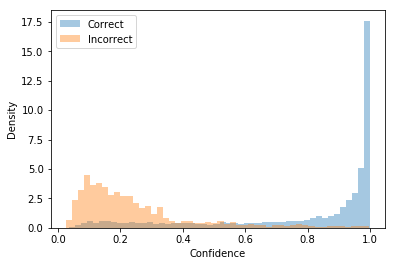

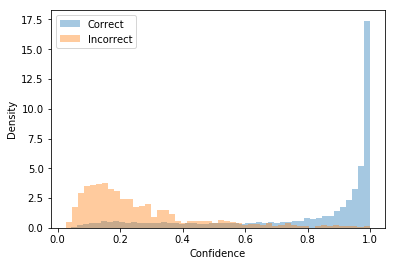

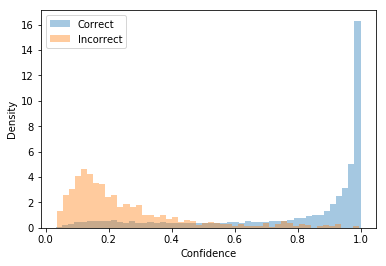

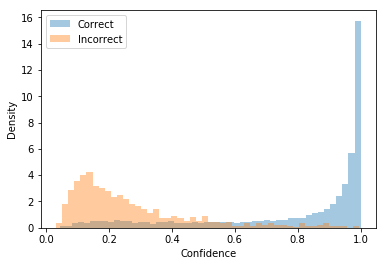

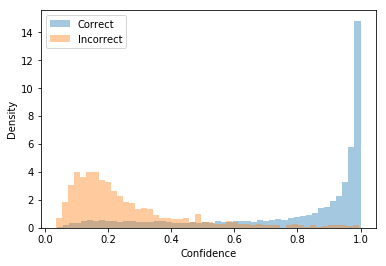

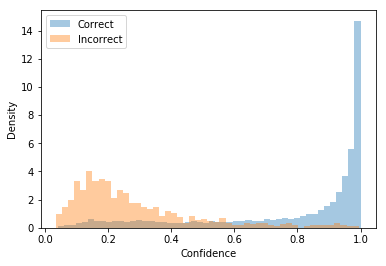

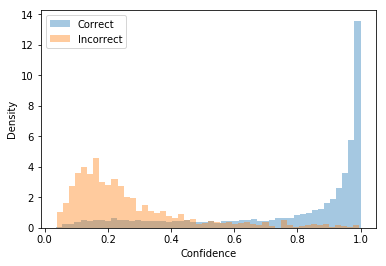

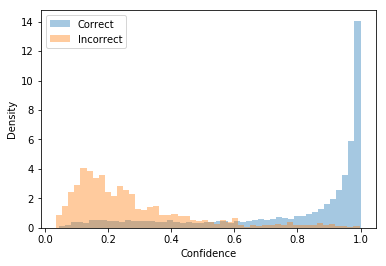

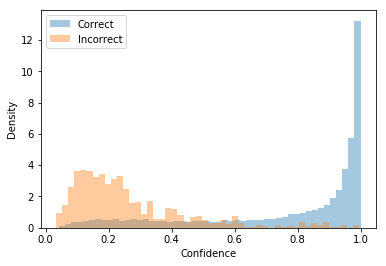

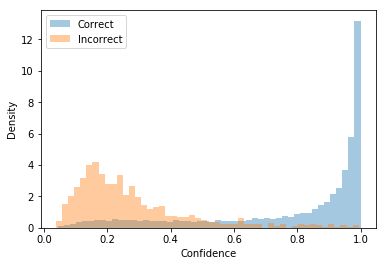

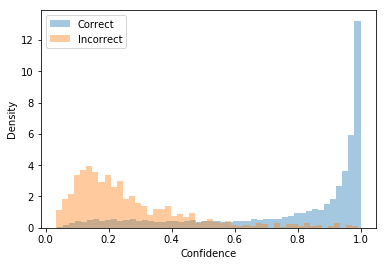

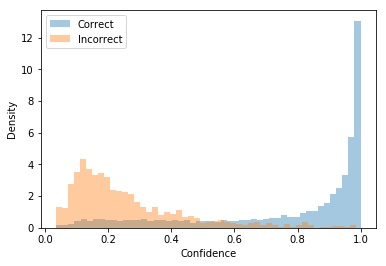

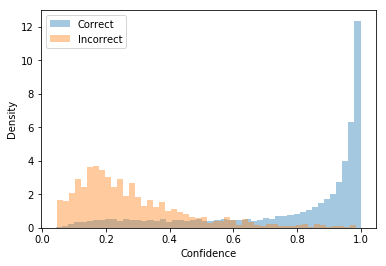

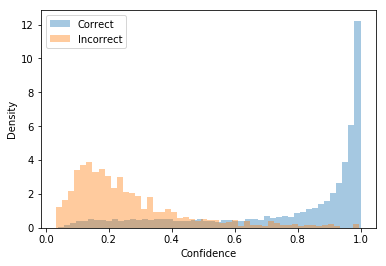

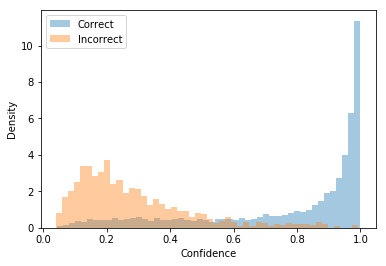

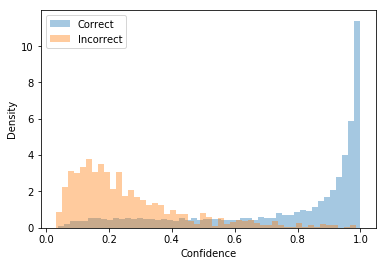

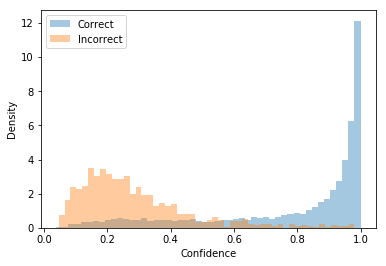

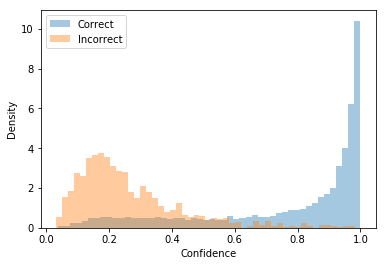

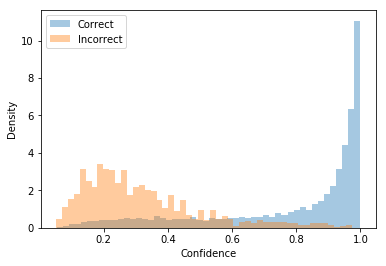

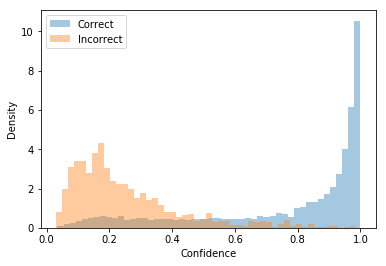

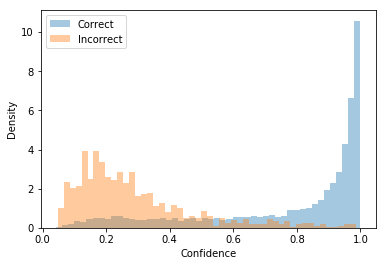

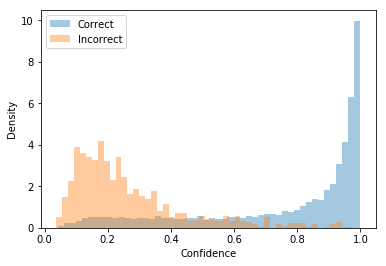

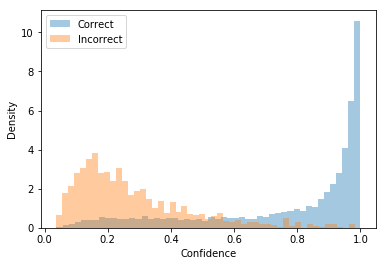

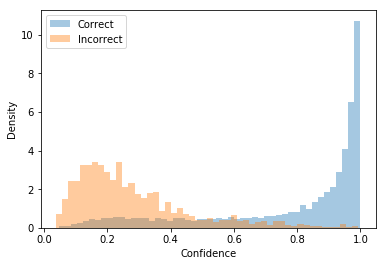

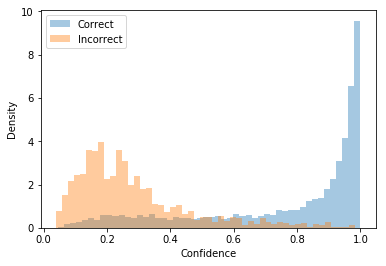

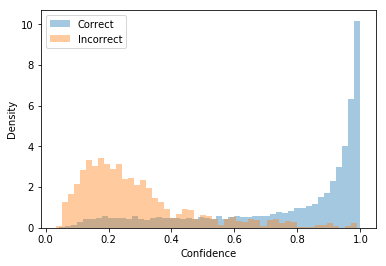

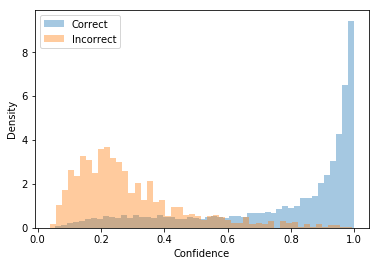

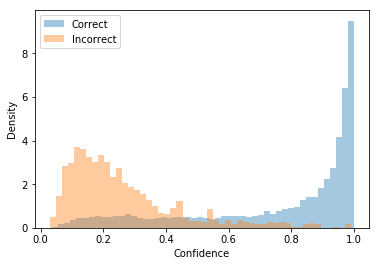

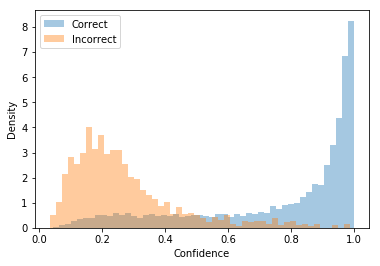

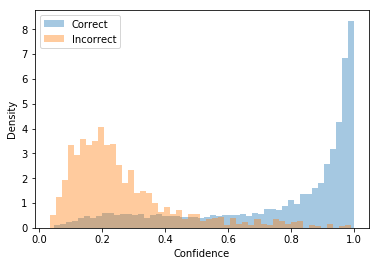

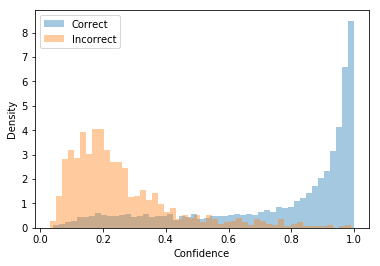

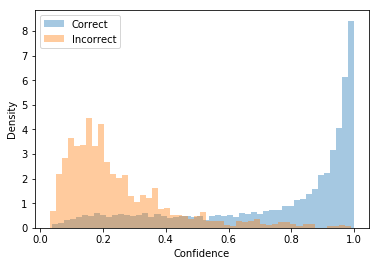

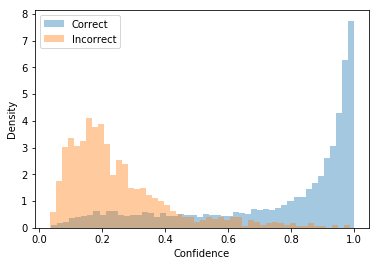

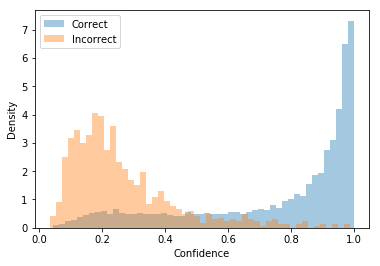

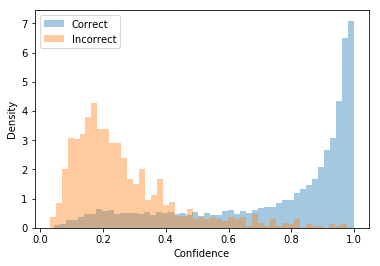

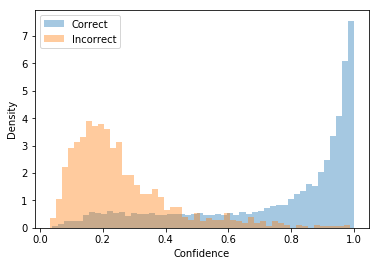

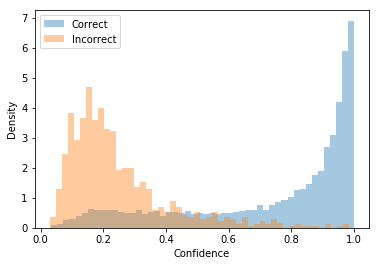

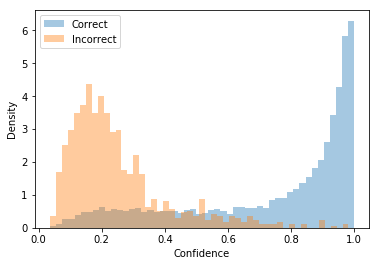

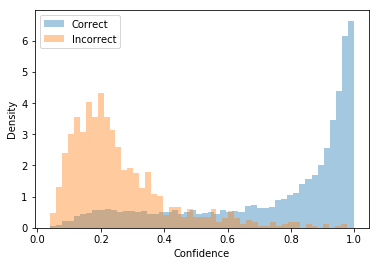

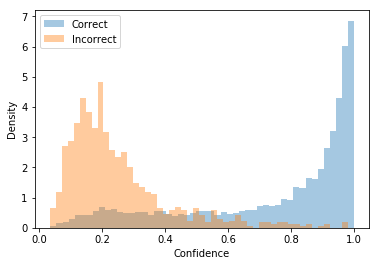

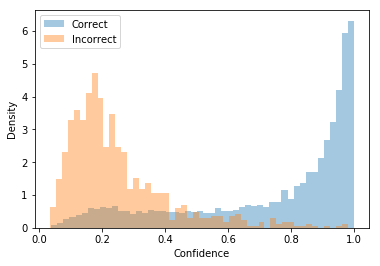

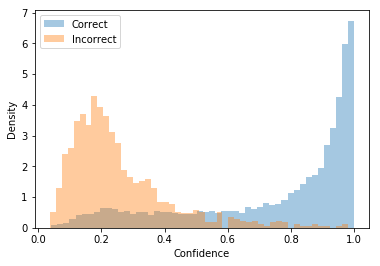

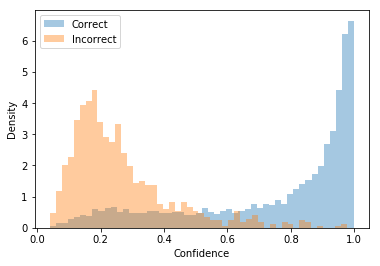

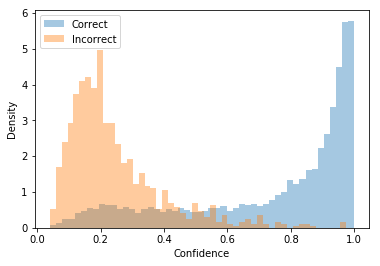

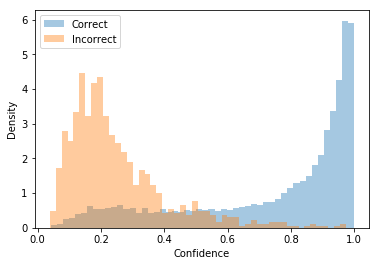

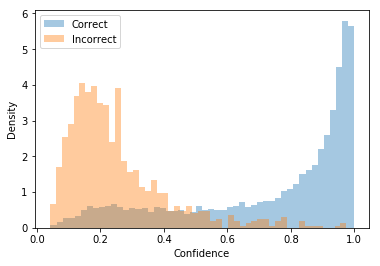

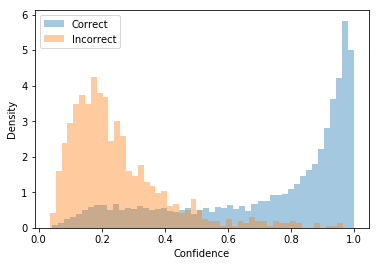

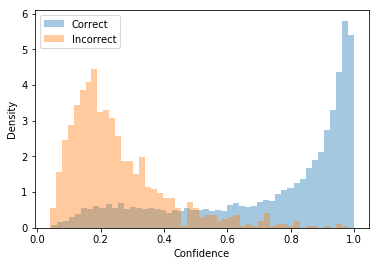

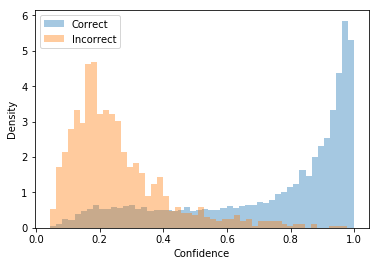

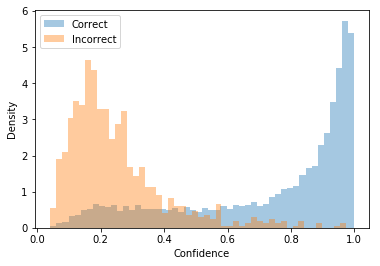

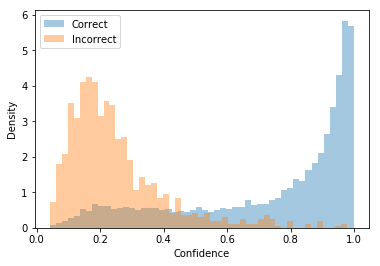

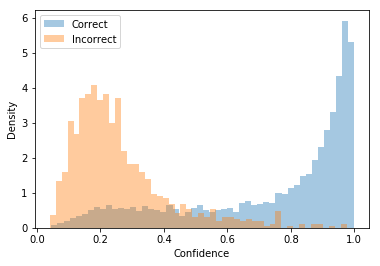

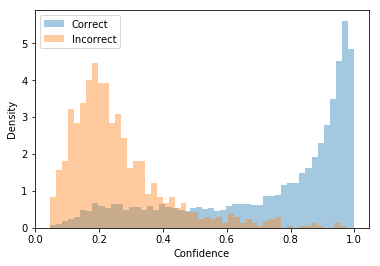

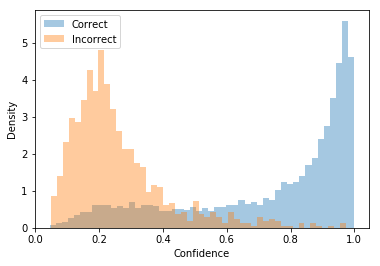

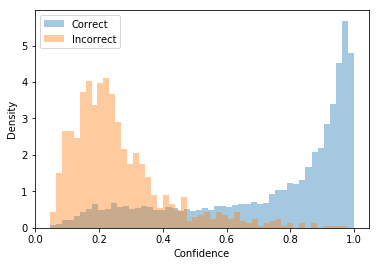

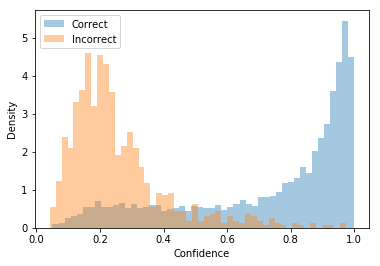

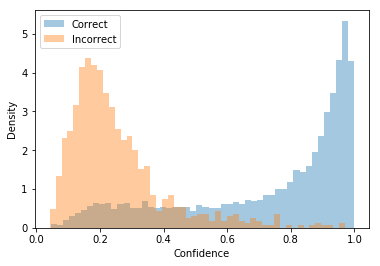

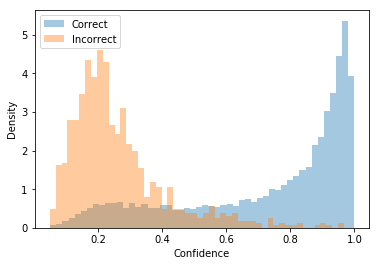

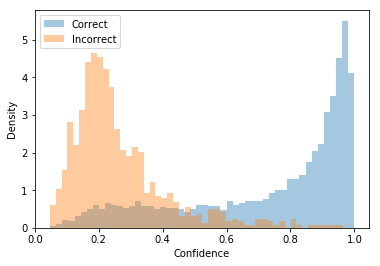

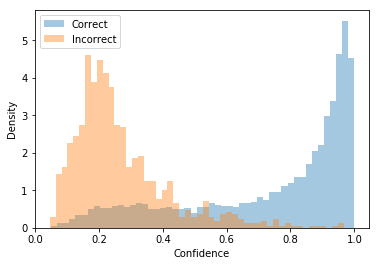

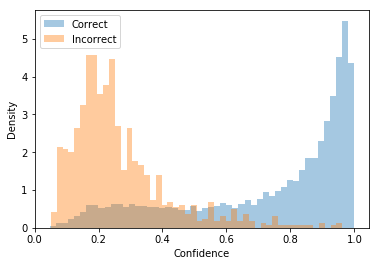

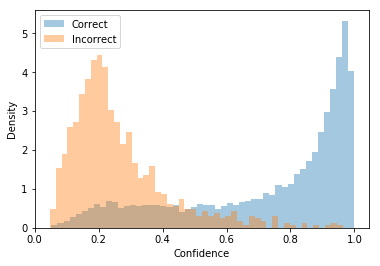

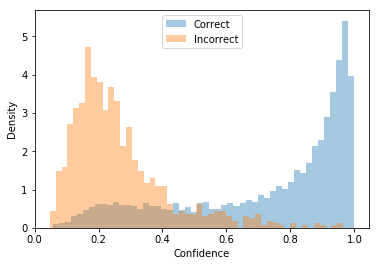

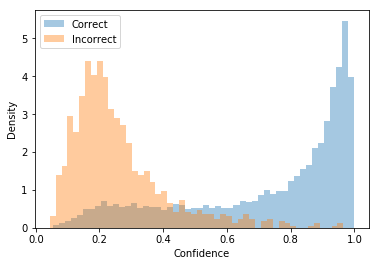

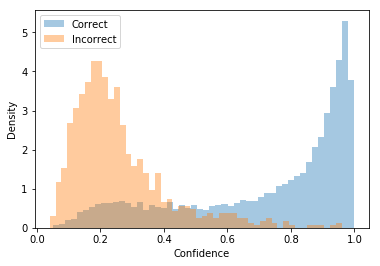

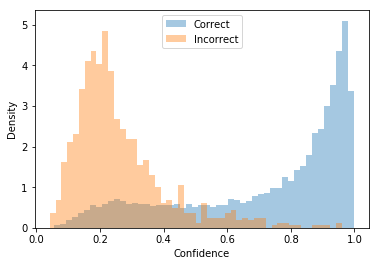

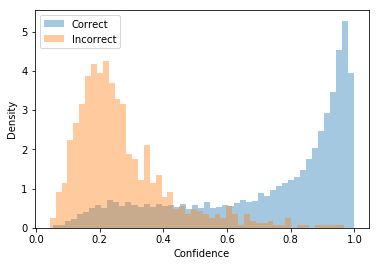

In [10]:
for epoch in range(epochs): # 200 epochs

    # 変数を初期化
    xentropy_loss_avg = 0.
    confidence_loss_avg = 0.
    correct_count = 0.
    total = 0.

    # プログレスバーを設定
    progress_bar = tqdm(train_loader)
    
    # バッチに分割する
    for i, (images, labels) in enumerate(progress_bar):
        progress_bar.set_description('Epoch ' + str(epoch))

        # Variableに変換
        images = Variable(images).cuda(async=True)
        labels = Variable(labels).cuda(async=True)
        labels_onehot = Variable(encode_onehot(labels, num_classes))
        
        # 勾配初期化
        cnn.zero_grad()

        # 順伝播
        pred_original, confidence = cnn(images)
        
        # 最終層の活性化
        pred_original = F.softmax(pred_original, dim=-1)
        confidence = F.sigmoid(confidence)

        # clampメソッドで数値を範囲内に収める
        eps = 1e-12
        pred_original = torch.clamp(pred_original, 0. + eps, 1. - eps)
        confidence = torch.clamp(confidence, 0. + eps, 1. - eps)

        # 予測値の補正を行う（ヒント部分）
        # Randomly set half of the confidences to 1 (i.e. no hints)
        b = Variable(torch.bernoulli(torch.Tensor(confidence.size()).uniform_(0, 1))).cuda()
        # confを設定
        conf = confidence * b + (1 - b)
        # 予測を小さくして、正解ラベルの分布を足す
        pred_new = pred_original * conf.expand_as(pred_original) + labels_onehot * (1 - conf.expand_as(labels_onehot))
        pred_new = torch.log(pred_new)

        # 損失計算
        xentropy_loss = prediction_criterion(pred_new, labels)
        confidence_loss = torch.mean(-torch.log(confidence))

        # 損失を定義
        total_loss = xentropy_loss + (lmbda * confidence_loss)
        if budget > confidence_loss.data[0]:
            lmbda = lmbda / 1.01
        elif budget <= confidence_loss.data[0]:
            lmbda = lmbda / 0.99

        # 逆伝播
        total_loss.backward()
        
        # パラメータの更新
        cnn_optimizer.step()

        # ロスの平均値を更新
        xentropy_loss_avg += xentropy_loss.data[0]
        confidence_loss_avg += confidence_loss.data[0]

        # 正解率を計算
        pred_idx = torch.max(pred_original.data, 1)[1]
        total += labels.size(0) # バッチサイズの累積
        correct_count += (pred_idx == labels.data).sum()
        accuracy = correct_count / total

        # プログレスバーを更新して表示
        progress_bar.set_postfix(
            xentropy='%.3f' % (xentropy_loss_avg / (i + 1)),
            confidence_loss='%.3f' % (confidence_loss_avg / (i + 1)),
            acc='%.3f' % accuracy)

    # 1epoch 終了
    # テストモードで検証を行う
    test_acc, conf_min, conf_max, conf_avg = test(test_loader)
    tqdm.write('test_acc: %.3f, conf_min: %.3f, conf_max: %.3f, conf_avg: %.3f' % (test_acc, conf_min, conf_max, conf_avg))

    # 学習率を更新する
    scheduler.step(epoch)

    # ログを記述する
    row = {'epoch': str(epoch), 'train_acc': str(accuracy), 'test_acc': str(test_acc)}
    csv_logger.writerow(row)

    # 重みを保存, 次のepochへ
    torch.save(cnn.state_dict(), 'checkpoints/' + filename + '.pt')

# 全epochが終了, ログを閉じる
csv_logger.close()